In [1]:
!pip install pyaurn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
import requests
import pyaurn
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [30, 15]
import os

from concurrent.futures import ThreadPoolExecutor, wait
from google.colab import drive
from shutil import make_archive, move
from math import sin, cos
from IPython.display import clear_output

In [3]:
metadata = pyaurn.importMeta().set_index("site_id")

In [4]:
display(metadata)
filtered_metadata = metadata.drop(["site_name", "parameter", "Parameter_name", "start_date", "end_date", "ratified_to", "agglomeration", "zone", "local_authority"], axis=1)

,site_name,location_type,latitude,longitude,parameter,Parameter_name,start_date,end_date,ratified_to,zone,agglomeration,local_authority
site_id,,,,,,,,,,,,
ABD,Aberdeen,Urban Background,57.157360,-2.094278,O3,Ozone,2003-08-01,2021-09-20,2021-09-20,North East Scotland,NaN,Aberdeen City
ABD9,Aberdeen Erroll Park,Urban Background,57.157400,-2.094770,O3,Ozone,2021-10-01,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ABD7,Aberdeen Union Street Roadside,Urban Traffic,57.144555,-2.106472,NO,Nitric oxide,2008-01-01,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ABD8,Aberdeen Wellington Road,Urban Traffic,57.133888,-2.094198,NO,Nitric oxide,2016-02-09,ongoing,2022-06-30,North East Scotland,NaN,Aberdeen City
ARM6,Armagh Roadside,Urban Traffic,54.353728,-6.654558,NO,Nitric oxide,2009-01-01,ongoing,2022-06-30,Northern Ireland,NaN,Armagh
...,...,...,...,...,...,...,...,...,...,...,...,...
WRAY,Wray,Rural Background,54.104666,-2.584182,O3,Ozone,1985-04-01,1988-02-29,1988-02-29,North West & Merseyside,NaN,Lancaster
WREX,Wrexham,Urban Traffic,53.042282,-3.002829,NO,Nitric oxide,2002-03-06,ongoing,2022-06-30,North Wales,NaN,Wrexham
YW,Yarner Wood,Rural Background,50.597600,-3.716510,O3,Ozone,1987-06-26,ongoing,2022-06-30,South West,NaN,Teignbridge


In [5]:
def get_site_data(name, year_range):
  try:
    data = pyaurn.importAURN(name, year_range).reset_index()
    data["site_id"] = name
    data["day"] = data["date"].dt.day
    data["month"] = data["date"].dt.month
    data["year"] = data["date"].dt.year
    data["hour"] = data["date"].dt.hour
    data["minute"] = data["date"].dt.minute
    data["second"] = data["date"].dt.second
    if "PM2.5" in data.columns:
      data = data[["day", "month", "year", "hour", "minute", "second", "PM2.5", "site_id"]]
      data = data.dropna()
      data = data.merge(filtered_metadata, on="site_id").drop("site_id", axis=1)
      return data
  except KeyError:
    return

In [6]:
display(metadata.index)
with ThreadPoolExecutor(min(32, os.cpu_count() + 4)) as executor:
  all_data = [executor.submit(get_site_data, name, range(2021, 2022)) for name in metadata.index]
  all_data = wait(all_data)
  clear_output()

In [7]:
retrieved_data = [item.result() for item in all_data.done]
display(retrieved_data[0])
concatenated_data = pd.concat(retrieved_data, ignore_index=True)
display(concatenated_data)

None

,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
0,1,1,2021,0,0,0,34.293,Urban Background,52.614823,1.302686
1,1,1,2021,1,0,0,24.623,Urban Background,52.614823,1.302686
2,1,1,2021,2,0,0,23.750,Urban Background,52.614823,1.302686
3,1,1,2021,3,0,0,24.175,Urban Background,52.614823,1.302686
4,1,1,2021,4,0,0,25.212,Urban Background,52.614823,1.302686
...,...,...,...,...,...,...,...,...,...,...
656745,31,12,2021,19,0,0,15.000,Urban Background,51.449674,-0.037418
656746,31,12,2021,20,0,0,12.170,Urban Background,51.449674,-0.037418
656747,31,12,2021,21,0,0,9.906,Urban Background,51.449674,-0.037418
656748,31,12,2021,22,0,0,7.830,Urban Background,51.449674,-0.037418


In [8]:
dataset_length = len(concatenated_data)

#train_dataset = concatenated_data[0:int(0.7*dataset_length)]
#val_dataset = concatenated_data[int(0.7*dataset_length):int(0.9*dataset_length)]
#test_dataset = concatenated_data[int(0.9*dataset_length):]

train_dataset = concatenated_data.sample(frac=0.7)
val_dataset = concatenated_data.drop(train_dataset.index).sample(frac=0.66)
test_dataset = concatenated_data.drop(train_dataset.index).drop(val_dataset.index)
display(train_dataset)
display(val_dataset)
display(test_dataset)

,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
390249,4,4,2021,12,0,0,10.900,Urban Traffic,53.404950,-1.455815
490955,3,3,2021,14,0,0,41.297,Urban Traffic,53.042282,-3.002829
639787,7,1,2021,0,0,0,11.769,Urban Background,54.883610,-1.406878
120579,3,5,2021,1,0,0,7.000,Urban Background,53.389225,-2.615593
434551,30,9,2021,17,0,0,0.200,Urban Traffic,50.832947,-0.379916
...,...,...,...,...,...,...,...,...,...,...
648600,14,1,2021,8,0,0,2.028,Urban Background,51.449674,-0.037418
575739,5,2,2021,20,0,0,10.000,Urban Traffic,54.565819,-1.315900
51686,6,7,2021,12,0,0,11.500,Urban Traffic,51.522530,-0.154611
267833,28,12,2021,8,0,0,6.000,Urban Industrial,56.010319,-3.704399


,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
37332,12,7,2021,14,0,0,8.000,Urban Background,50.840836,-0.147572
245733,18,5,2021,22,0,0,4.000,Urban Background,55.002818,-7.331179
41676,7,5,2021,12,0,0,4.057,Urban Traffic,55.944079,-4.734421
294069,12,2,2021,14,0,0,8.915,Urban Background,53.765590,-2.680353
271865,22,6,2021,4,0,0,10.000,Urban Background,50.739570,-1.826744
...,...,...,...,...,...,...,...,...,...,...
360107,17,10,2021,8,0,0,5.000,Urban Background,57.157400,-2.094770
23444,23,11,2021,22,0,0,1.300,Urban Traffic,51.632696,-3.947374
205630,26,3,2021,1,0,0,7.995,Urban Background,51.521050,-0.213492
236623,10,3,2021,3,0,0,5.000,Urban Traffic,51.074793,-4.041924


,day,month,year,hour,minute,second,PM2.5,location_type,latitude,longitude
9,1,1,2021,9,0,0,28.868,Urban Background,52.614823,1.302686
10,1,1,2021,10,0,0,25.495,Urban Background,52.614823,1.302686
15,1,1,2021,15,0,0,19.717,Urban Background,52.614823,1.302686
17,1,1,2021,17,0,0,22.995,Urban Background,52.614823,1.302686
21,1,1,2021,21,0,0,10.920,Urban Background,52.614823,1.302686
...,...,...,...,...,...,...,...,...,...,...
656735,31,12,2021,9,0,0,3.208,Urban Background,51.449674,-0.037418
656739,31,12,2021,13,0,0,3.396,Urban Background,51.449674,-0.037418
656743,31,12,2021,17,0,0,11.887,Urban Background,51.449674,-0.037418
656745,31,12,2021,19,0,0,15.000,Urban Background,51.449674,-0.037418


In [9]:
train_features = train_dataset.copy()
val_features = val_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop("PM2.5")
val_labels = val_features.pop("PM2.5")
test_labels = test_features.pop("PM2.5")

train_features.shape

(459725, 9)

In [10]:
def split_data_for_preprocessing(dataset):
  text_cols = ["location_type"]
  number_cols = ["day", "month", "year", "hour", "minute", "second", "latitude", "longitude"]

  return (dataset[number_cols], dataset[text_cols])

In [11]:
train_features_split = split_data_for_preprocessing(train_features)
val_features_split = split_data_for_preprocessing(val_features)
test_features_split = split_data_for_preprocessing(test_features)

print(train_features_split[0].info())
print(train_features_split[1].info())
print(pd.unique(train_features_split[1]["location_type"]))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 390249 to 203863
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   day        459725 non-null  int64  
 1   month      459725 non-null  int64  
 2   year       459725 non-null  int64  
 3   hour       459725 non-null  int64  
 4   minute     459725 non-null  int64  
 5   second     459725 non-null  int64  
 6   latitude   459725 non-null  float64
 7   longitude  459725 non-null  float64
dtypes: float64(2), int64(6)
memory usage: 31.6 MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 459725 entries, 390249 to 203863
Data columns (total 1 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   location_type  459725 non-null  object
dtypes: object(1)
memory usage: 7.0+ MB
None
['Urban Traffic' 'Urban Background' 'Suburban Background'
 'Rural Background' 'Urban Industrial']


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 8)]          0           []                               
                                                                                                  
 string_lookup (StringLookup)   (None, 6)            0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 8)            17          ['input_2[0][0]']                
                                                                                              

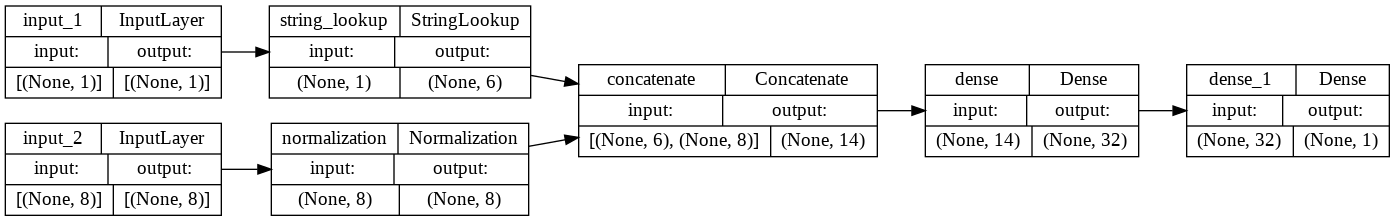

In [12]:
vocabulary = np.array(pd.unique(train_features["location_type"]))
category_inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string)
lookup_layer = tf.keras.layers.StringLookup(vocabulary=vocabulary, output_mode="multi_hot")(category_inputs)

numeric_inputs = tf.keras.layers.Input(shape=(8,))
normalisation_layer = tf.keras.layers.Normalization()
normalisation_layer.adapt(train_features_split[0])
normalisation_layer = normalisation_layer(numeric_inputs)

concatenated_inputs = tf.keras.layers.concatenate([lookup_layer, normalisation_layer])
dense_layer = tf.keras.layers.Dense(32, activation="tanh")(concatenated_inputs)
outputs = tf.keras.layers.Dense(1)(dense_layer)

model = tf.keras.Model(inputs=[category_inputs, numeric_inputs], outputs=outputs)

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")


In [13]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_squared_error",
    metrics = ["mean_absolute_error"]
)

In [14]:
print(train_features.dtypes)
history = model.fit(
    (train_features_split[1], train_features_split[0]),
    train_labels,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=1, min_lr=0.001),
        tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1)

    ],
    validation_data = ((val_features_split[1], val_features_split[0]), val_labels)
)

day                int64
month              int64
year               int64
hour               int64
minute             int64
second             int64
location_type     object
latitude         float64
longitude        float64
dtype: object
Epoch 1/10
14367/14367 [==============================] - 84s 6ms/step - loss: 41.1736 - mean_absolute_error: 4.3520 - val_loss: 38.0390 - val_mean_absolute_error: 4.2000 - lr: 0.1000
Epoch 2/10
14367/14367 [==============================] - 83s 6ms/step - loss: 38.6546 - mean_absolute_error: 4.2410 - val_loss: 41.0020 - val_mean_absolute_error: 4.2741 - lr: 0.1000
Epoch 3/10
14367/14367 [==============================] - 83s 6ms/step - loss: 35.2032 - mean_absolute_error: 4.0152 - val_loss: 34.2182 - val_mean_absolute_error: 3.9958 - lr: 0.0200
Epoch 4/10
14367/14367 [==============================] - 85s 6ms/step - loss: 34.9920 - mean_absolute_error: 3.9991 - val_loss: 34.4361 - val_mean_absolute_error: 4.0958 - lr: 0.0200
Epoch 5/10
14367/14367 [=

{'loss': [41.173583984375,
  38.65456008911133,
  35.2032470703125,
  34.99196243286133,
  34.43894577026367,
  34.38362121582031,
  34.36528015136719,
  34.35071563720703,
  34.250186920166016,
  34.24458694458008],
 'mean_absolute_error': [4.351953983306885,
  4.241034507751465,
  4.01518440246582,
  3.9991023540496826,
  3.958742380142212,
  3.9554059505462646,
  3.9545111656188965,
  3.952127456665039,
  3.9428491592407227,
  3.944119930267334],
 'val_loss': [38.03899383544922,
  41.002037048339844,
  34.21821594238281,
  34.43613815307617,
  33.751976013183594,
  33.74387741088867,
  33.70909881591797,
  33.76862716674805,
  33.648807525634766,
  33.64226531982422],
 'val_mean_absolute_error': [4.2000274658203125,
  4.274148941040039,
  3.9958269596099854,
  4.0958147048950195,
  3.9320261478424072,
  3.8992700576782227,
  3.9222474098205566,
  3.8938703536987305,
  3.951411485671997,
  3.9550633430480957],
 'lr': [0.1,
  0.1,
  0.02,
  0.02,
  0.0039999997,
  0.0039999997,
  0.00

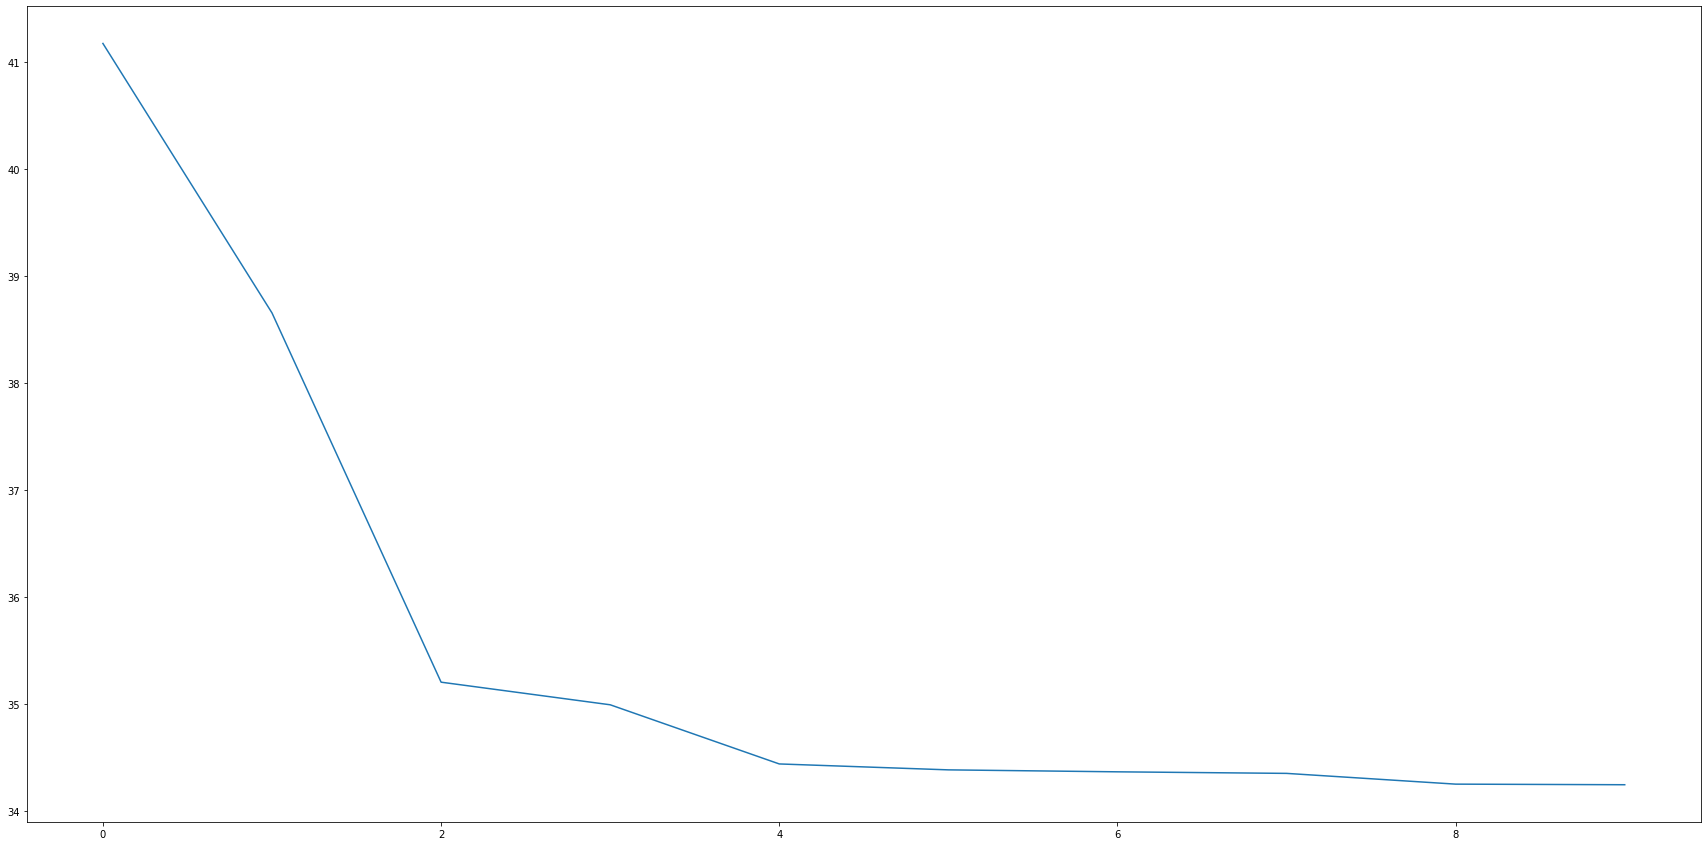

In [18]:
display(history.history)
plt.plot(history.history["loss"])
plt.show()

2094/2094 [==============================] - 4s 2ms/step


array([8.516369 , 8.51742  , 8.523146 , ..., 6.8962193, 9.060537 ,
       9.062832 ], dtype=float32)

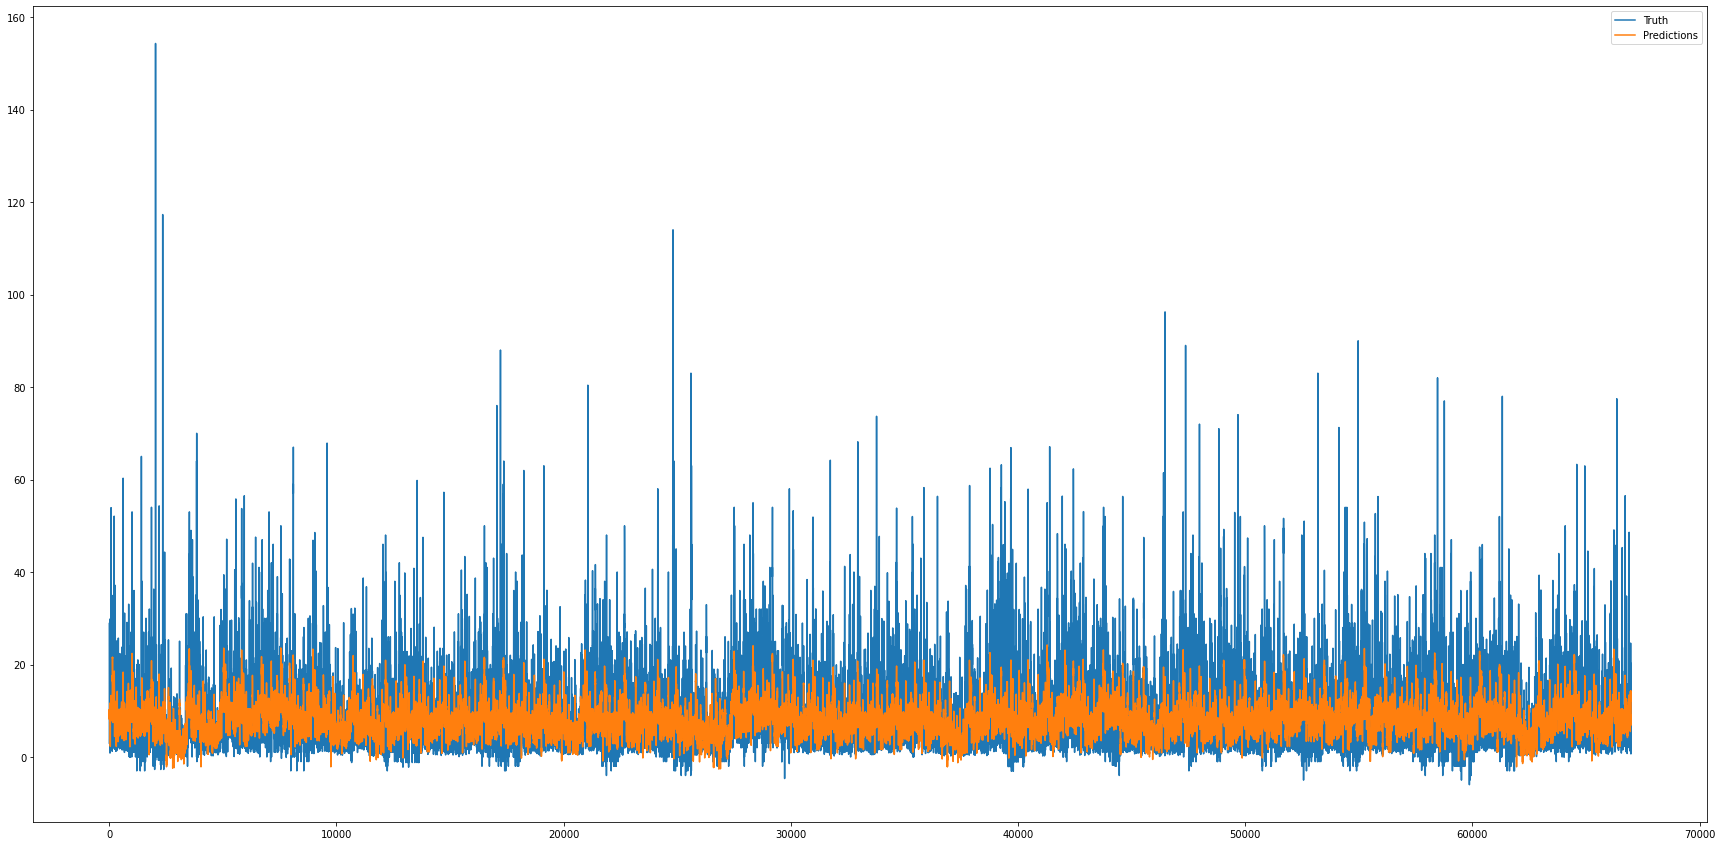

In [19]:
predictions = model.predict([test_features_split[1], test_features_split[0]]).flatten()
display(predictions)
plt.plot(test_labels.reset_index(drop=True), label="Truth")
plt.plot(predictions, label="Predictions")
plt.legend()

In [17]:
#drive.mount("/content/gdrive", force_remount=True)
model.save("/content/comp3000model")
zip_location = make_archive("model", "zip", "/content/comp3000model")
#move(zip_location, "/content/gdrive/MyDrive/comp3000model/model.zip")
#drive.flush_and_unmount()